## DNN (Learning dynamic)

In this approach, we will learn the second derivative of θ'', given θ and θ'. In this experiment we want to proof that learning dynamic can help model to learn underlying dynamical system. Also this provides as with solid baseline.


In [ ]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from utils import *
from copy import copy

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_seed(42)


In [3]:
L = 4
M = 2
G = 9.8
simulation_duration = 10

dt = .01
rk_integrator_args = {}
rk_integrator_args['rtol'] = 1e-13
rk_integrator_args['method'] = 'RK45'
rk_integrator_args['atol'] = 1e-10

odeint_integrator_args = {}
odeint_integrator_args['rtol'] = 1e-13
odeint_integrator_args['atol'] = 1e-10
odeint_integrator_args['full_output'] = 1

Generate training data with an initial angle of 80 degrees and zero angular velocity.

In [4]:
t_train = np.arange(0, simulation_duration, dt)
initial_pendulum_config = np.array([np.deg2rad(80), 0])
x_train_theta, train_joints_over_time, x_train = compute_thetas_over_time(simulation_duration, dt, initial_pendulum_config, rk_integrator_args, G, L)

Generate training data with an initial angle of 65 degrees and zero angular velocity. Train and test data is different to check generalizability

In [5]:
t_test = np.arange(0, simulation_duration, dt)
test_initial_pendulum_config = np.array([np.deg2rad(65),0])
x_test_theta ,test_joints_over_time,x_test = compute_thetas_over_time(simulation_duration, dt, test_initial_pendulum_config, rk_integrator_args, G, L)

Find true derivatives (in this appproach we will use only second derivative)

In [6]:
true_derivatives = []
for i in range(len(t_train)):
    true_derivatives.append(pendulum_motion(t_train[i], x_train.T[i], G, L))

true_derivatives=np.array(true_derivatives)

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class PendulumDataset(Dataset):
    def __init__(self, data, targets):
        self.inputs = torch.tensor(data.T, dtype=torch.float32)
        self.targets = torch.tensor(targets[:, 1], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(),
            nn.Linear(128, 128),
            nn.Softplus(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

    def train_dnn(self, dataloader, epochs=1000, lr=0.001):
        """Train LNN model"""
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        loss_history = []

        for epoch in range(epochs):
            total_loss = 0
            for x_batch, y_batch in dataloader:
                optimizer.zero_grad()
                predicted_ddot = self(x_batch)
                loss = criterion(predicted_ddot, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * len(x_batch)

            avg_loss = total_loss / len(dataloader.dataset)
            loss_history.append(avg_loss)
            if epoch % 1 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
        return loss_history


Epoch 0/10, Loss: 2.529008
Epoch 1/10, Loss: 0.371328
Epoch 2/10, Loss: 0.033731
Epoch 3/10, Loss: 0.028695
Epoch 4/10, Loss: 0.028360
Epoch 5/10, Loss: 0.028732
Epoch 6/10, Loss: 0.027756
Epoch 7/10, Loss: 0.028137
Epoch 8/10, Loss: 0.028207
Epoch 9/10, Loss: 0.027894


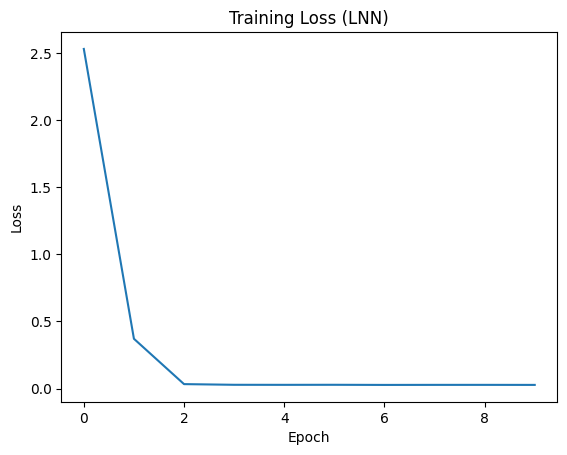

In [14]:
dataset = PendulumDataset(x_train, true_derivatives)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

lnn_model = DNN()
loss = lnn_model.train_dnn(dataloader, epochs=10, lr=0.0005)

plt.plot(range(len(loss)), loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (LNN)")
plt.show()


In [17]:
def learned_pendulum_dynamics(y, t, model):
    """Use learned differential equation"""
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
    ddot_theta = model(y_tensor).squeeze().item()
    return [y[1], ddot_theta]


Integrating to find θ at each time step, we use the odeint integrator, which adapts the method to the stiffness of the ODE. It is also the default choice for SINDy.

In [18]:
from scipy.integrate import odeint
test_initial_pendulum_config = np.array([np.deg2rad(65), 0.0])
t = np.arange(0, simulation_duration, 0.01)
solution = odeint(learned_pendulum_dynamics, test_initial_pendulum_config, t, args=(lnn_model,))


Visualize theta acceleration

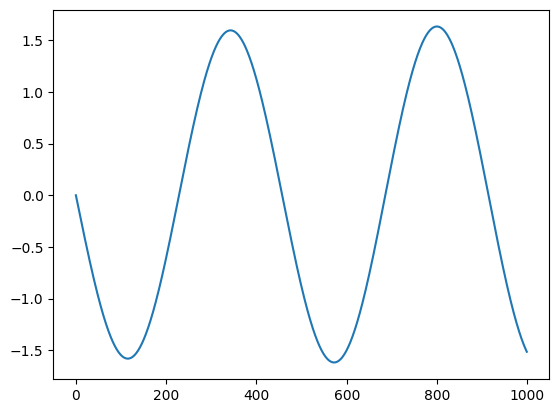

In [19]:
plt.plot(range(len(solution[:, 1])), solution[:, 1])

Make visualization of learned dynamic and save into file

In [20]:
informed_simulation = solution.T
informed_simulation[0] = loop_around_angles(informed_simulation[0])
joints_over_time_informed = compute_joints_position(informed_simulation[0], L)

In [21]:
animate_pendulum_versus(test_joints_over_time, joints_over_time_informed,"our_informed_single_pendulum.mp4", interval=0.003, fps=240)